<a href="https://colab.research.google.com/github/foxrain-05/Learning-Deep-Learning/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Activation, Dropout, Flatten, Dense, LeakyReLU, Input,BatchNormalization, Reshape, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

In [ ]:
gpus = tf.config.experimental.list_physical_devices('/device:GPU:0')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

In [ ]:
input_dim = (512, 512, 3)
discriminator_conv_filters = [32, 32, 64, 64, 128, 128]
discriminator_conv_kernel_size = [5, 5, 5, 5, 3, 3]
discriminator_conv_strides = [2, 2, 2, 2, 2, 2]
discriminator_batch_norm_momentum = None
discriminator_dropout_rate = 0.4
discriminator_learning_rate = 0.0008
          
generator_initial_dense_layer_size = (8, 8, 64)
generator_upsample = [2, 2, 2, 2, 1, 1]
generator_conv_filters = [128, 64, 64, 32, 32, 3]
generator_conv_kernel_size = [5, 5, 5, 5, 5, 5]
generator_conv_strides = [1, 1, 1, 1, 1, 1]
generator_batch_norm_momentum = 0.9
generator_dropout_rate = None
generator_learning_rate = 0.0004

optimiser = "rmsprop"
z_dim = 500

n_layer_discriminator = 6
n_layer_generator = 6
        

In [ ]:
def model_generator():
    generator_input = Input(shape=(z_dim, ), name="generator_input")
    x = generator_input

    x = Dense(np.prod(generator_initial_dense_layer_size))(x)

    if generator_batch_norm_momentum:
        x = BatchNormalization(momentum = generator_batch_norm_momentum)(x)
    x = Activation(LeakyReLU(0.2))(x)

    x = Reshape(generator_initial_dense_layer_size)(x)

    if generator_dropout_rate:
        x = Dropout(rate = generator_dropout_rate)(x)

    for i in range(n_layer_generator):
        x = UpSampling2D()(x)
        x = Conv2D(
            filters = generator_conv_filters[i],
            kernel_size = generator_conv_kernel_size[i],
            padding = 'same',
            name = 'generator_conv_'+str(i)
        )(x)

        if i < n_layer_generator - 1:
            if generator_batch_norm_momentum:
                x = BatchNormalization(momentum = generator_batch_norm_momentum)(x)
            x = Activation(LeakyReLU(0.2))(x)
        else:
            x = Activation("tanh")(x)

    generator_output = x
    generator = Model(generator_input, generator_output)
    return generator

In [ ]:
generator = model_generator()
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_input (InputLayer  [(None, 500)]            0         
 )                                                               
                                                                 
 dense (Dense)               (None, 4096)              2052096   
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 64)       0     

In [ ]:
def model_discriminator():
    discriminator_input = Input(shape=input_dim, name="discriminator_input")
    x = discriminator_input

    for i in range(n_layer_discriminator):
        x = Conv2D(
            filters = discriminator_conv_filters[i],
            kernel_size = discriminator_conv_kernel_size[i],
            strides = discriminator_conv_strides[i],
            padding = "same",
            name="discriminator_conv_"+str(i)+"_layer"
        )(x)
        if discriminator_batch_norm_momentum and i > 0:
            x = BatchNormalization(momentum = discriminator_batch_norm_momentum)(x)

        x = Activation(LeakyReLU(0.2))(x)

        if discriminator_dropout_rate:
            x = Dropout(rate = discriminator_dropout_rate)(x)

    x = Flatten()(x)
    discriminator_output = Dense(1, activation="sigmoid", kernel_initializer='random_uniform')(x)
    discriminator = Model(discriminator_input, discriminator_output)

    discriminator.trainable = False
    #discriminator.summary()

    discriminator.compile(
        optimizer=RMSprop(learning_rate=discriminator_learning_rate),
        loss = "binary_crossentropy",
        metrics = ["accuracy"]
    )
    discriminator.trainable = False
    return discriminator

In [ ]:
discriminator = model_discriminator()
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (InputL  [(None, 512, 512, 3)]    0         
 ayer)                                                           
                                                                 
 discriminator_conv_0_layer   (None, 256, 256, 32)     2432      
 (Conv2D)                                                        
                                                                 
 activation_7 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 dropout (Dropout)           (None, 256, 256, 32)      0         
                                                                 
 discriminator_conv_1_layer   (None, 128, 128, 32)     25632     
 (Conv2D)                                                        
                                                           

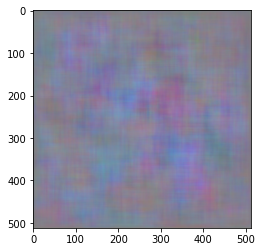

In [ ]:
noise = tf.random.normal([4, 500])

generated_image = generator(noise, training=False)
plt.imshow((generated_image[0, :, :, :] * 0.5 + 0.5))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 379 images belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


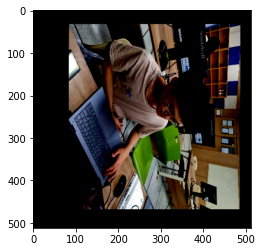

In [ ]:
get_data = ImageDataGenerator(#rescale=1./255,
                                    horizontal_flip=True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    rotation_range=4,
                                    shear_range=0.4,
                                    zoom_range=[0.9, 1.2],
                                    fill_mode="nearest")
    
train_image = get_data.flow_from_directory(
            "/content/drive/MyDrive/kt_gan/image",
            classes=['re_kt'],
            target_size = (512, 512),
            batch_size = 378,
            class_mode="binary")
train_image = train_image[0][0]

train_image = (train_image - 127.5) / 127.5

plt.imshow(train_image[0, :, :, :])

In [ ]:
model_input = Input(shape=(500, ), name="gan_input")
discriminator_output = discriminator(generator(model_input))
model = Model(model_input, discriminator_output)
model.compile(loss="binary_crossentropy", optimizer="adam")
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gan_input (InputLayer)      [(None, 500)]             0         
                                                                 
 model (Functional)          (None, 512, 512, 3)       2661283   
                                                                 
 model_1 (Functional)        (None, 1)                 411425    
                                                                 
Total params: 3,072,708
Trainable params: 2,652,451
Non-trainable params: 420,257
_________________________________________________________________


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_image).shuffle(376).batch(4)

In [ ]:
def gan_input(epochs, batch_size, save_point):
    
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for epoch in range(epochs):
        train_data = iter(train_dataset)
        discriminator.train_on_batch(next(train_data), valid)

        noise = np.random.normal(0, 1, (4, 500))
        generator_imgs = generator.predict(noise)
        discriminator.train_on_batch(generator_imgs, fake)

        generator_loss = model.train_on_batch(noise, valid)
        print(f"epoch: {epoch}")

        if epoch % save_point == 0:
            noise = tf.random.normal([4, 500])
            gan_imgs = generator.predict(noise)
            gan_imgs = 0.5 * gan_imgs + 0.5

            for i in range(gan_imgs.shape[0]):
                plt.imsave(f'/content/drive/MyDrive/kt_gan/gan_image/{epoch}_{i}.png', gan_imgs[i])

In [ ]:
gan_input(10001, 4, 20)

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
epoch: 66
epoch: 67
epoch: 68
epoch: 69
epoch: 70
epoch: 71
epoch: 72
epoch: 73
epoch: 74
epoch: 75
epoch: 76
epoch: 77
epoch: 78
epoch: 79
epoch: 80
epoch: 81
epoch: 82
epoch: 83
epoch: 84
epoch: 85
epoch: 86
epoch: 87
epoch: 88
epoch: 89
epoch: 90


In [ ]:
decision = discriminator(generated_image)
decision = discriminator(train_image)

In [ ]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices()[1])